In [2]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

In [20]:
# symbols = 'BTC'.split(',')
# symbols = 'ETH'.split(',')
# symbols = 'BNB'.split(',')
# symbols = 'ATOM'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True, horizon=4)
df.to_pickle('/tmp/df_horizon4.pkl')
# df.to_pickle('/tmp/df_horizon4_eth.pkl')
# df.to_pickle('/tmp/df_horizon4_bnb.pkl')
# df.to_pickle('/tmp/df_horizon4_atom.pkl')
display(df)

op            hi            lo  \
timestamp                 symbol                                             
2019-07-20 00:00:00+00:00 BNB        29.074200     29.251700     28.981150   
                          BTC     10532.400561  10596.176732  10451.465293   
                          ETH       221.191514    224.079639    221.015166   
                          XRP         0.319763      0.323658      0.319140   
2019-07-20 01:00:00+00:00 BNB        29.102050     30.051750     28.937300   
...                                        ...           ...           ...   
2022-09-21 13:00:00+00:00 ETH      1355.637143   1357.141429   1346.238571   
                          LINK        7.024996      7.056310      6.999155   
                          MATIC       0.736804      0.741737      0.734849   
                          SOL        32.171760     32.214971     31.926797   
                          XRP         0.403442      0.405303      0.399562   

                                            cl        execution_start_at  \
timestamp                 symbol                                           
2019-07-20 00:00:00+00:00 BNB        29.102300 2019-07-20 01:00:00+00:00   
                          BTC     10466.256172 2019-07-20 01:00:00+00:00   
                          ETH       221.450416 2019-07-20 01:00:00+00:00   
                          XRP         0.319678 2019-07-20 01:00:00+00:00   
2019-07-20 01:00:00+00:00 BNB        30.036500 2019-07-20 02:00:00+00:00   
...                                        ...                       ...   
2022-09-21 13:00:00+00:00 ETH      1348.208571 2022-09-21 14:00:00+00:00   
                          LINK        7.031510 2022-09-21 14:00:00+00:00   
                          MATIC       0.739579 2022-09-21 14:00:00+00:00   
                          SOL        32.111567 2022-09-21 14:00:00+00:00   
                          XRP         0.402523 2022-09-21 14:00:00+00:00   

                                       ret  
timestamp                 symbol            
2019-07-20 00:00:00+00:00 BNB     0.032211  
                          BTC     0.015201  
                          ETH     0.028712  
                          XRP     0.030553  
2019-07-20 01:00:00+00:00 BNB     0.001236  
...                                    ...  
2022-09-21 13:00:00+00:00 ETH          NaN  
                          LINK         NaN  
                          MATIC        NaN  
                          SOL          NaN  
                          XRP          NaN  

[250363 rows x 6 columns]

In [9]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor
from functools import partial

class ExampleModelRank:
    def __init__(self):
        ridge = Ridge(fit_intercept=False, alpha=1e5)
        
        bagging_n = 5
        
        rf = lgb.LGBMRegressor(
            n_estimators=100,
            learning_rate=0.1,
            # extra_trees=True,
            bagging_fraction=0.5,
            bagging_freq=3,
            boosting='rf',
            # colsample_bytree=0.9,
            # reg_lambda=1,
            random_state=1,
            n_jobs=-1,
        )
        rf = BaggingRegressor(
            rf,
            n_estimators=bagging_n,
            # max_samples=0.9,
            # bootstrap=False,
            # max_features=0.9,
            random_state=1
        )
        
        rf_clf = lgb.LGBMClassifier(
            n_estimators=100,
            learning_rate=0.1,
            # extra_trees=True,
            bagging_fraction=0.5,
            bagging_freq=3,
            boosting='rf',
            # colsample_bytree=0.9,
            # reg_lambda=1,
            random_state=1,
            n_jobs=-1,
        )
        rf_clf = BaggingRegressor(
            rf_clf,
            n_estimators=bagging_n,
            # max_samples=0.9,
            # bootstrap=False,
            # max_features=0.9,
            random_state=1
        )
        
        rf_et = lgb.LGBMRegressor(
            n_estimators=100,
            learning_rate=0.1,
            extra_trees=True,
            bagging_fraction=0.5,
            bagging_freq=3,
            boosting='rf',
            # colsample_bytree=0.9,
            # reg_lambda=1,
            random_state=1,
            n_jobs=-1,
        )
        rf_et = BaggingRegressor(
            rf_et,
            n_estimators=bagging_n,
            # max_samples=0.9,
            # bootstrap=False,
            # max_features=0.9,
            random_state=1
        )
        
        lgbm = lgb.LGBMRegressor(
            n_estimators=100,
            learning_rate=0.1,
            extra_trees=True,
            # colsample_bytree=0.9,
            # reg_lambda=1,
            random_state=1,
            n_jobs=-1,
        )
        lgbm = BaggingRegressor(
            lgbm,
            n_estimators=bagging_n,
            max_samples=0.9,
            bootstrap=False,
            # max_features=0.9,
            random_state=1
        )
            
        lgbm_clf = lgb.LGBMClassifier(
            n_estimators=100,
            learning_rate=0.1,
            extra_trees=True,
            # colsample_bytree=0.9,
            # reg_lambda=1,
            random_state=1,
            n_jobs=-1,
        )
        lgbm_clf = BaggingRegressor(
            lgbm_clf,
            n_estimators=bagging_n,
            max_samples=0.9,
            bootstrap=False,
            # max_features=0.9,
            random_state=1
        )
        
        # self._model = ridge
        # self._model = rf
        # self._model = rf_clf
        # self._model = lgbm
        # self._model = lgbm_clf
        
        self._model = VotingRegressor([
            # ('ridge', ridge),
            ('lgbm', lgbm),
            # ('lgbm_clf', lgbm_clf),
            ('rf', rf),
            ('rf_et', rf_et),
        ], weights=[
            # 0.2,
            1,
            # 0.5,
            1,
            1,
        ])
        
        self._model = Pipeline([
            ('ss', StandardScaler()),
            ('model', self._model)
        ])
        
        self.max_data_sec = 14 * 24 * 60 * 60 # for predict script
        self.horizon = 4

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        # df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-4) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script 
        # return self._model.fit(df[features], df['ret_train'])
        # return self._model.fit(df[features], np.sign(df['ret_train']), sample_weight=np.abs(df['ret_train']))
        return self._model.fit(df[features], np.sign(df['ret_train']), model__sample_weight=np.abs(df['ret_train']))
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        # df['position'] = 0.0
        # for m in self._model.estimators_:
        #     y_pred = m.predict(df[features])
        #     df['position'] = np.sign(y_pred)
        # df['position'] /= len(self._model.estimators_)
        
        y_pred = self._model.predict(df[features])
        df['position'] = np.sign(y_pred)
        
        # df['position'] = y_pred
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.2))
        
        # normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):        
        df = df.copy()
        
        df['ln_hilo'] = 0.5 * (np.log(df['hi']) + np.log(df['lo']))
        df['ln_hilocl'] = (np.log(df['hi']) + np.log(df['lo']) + np.log(df['cl'])) / 3
        
        df['ln_cl'] = np.log(df['cl'])
        df['ln_cl_diff'] = (df['ln_cl'] - df.groupby('symbol')['ln_cl'].shift(1)).fillna(0)
        df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
        
        t = df.index.get_level_values('timestamp')
        df['t'] = t.dayofweek * 24 + t.hour
        
        # assume single symbol
        df.loc[df['t'] == 0, 'cl_monday_op'] = df.loc[df['t'] == 0, 'cl']
        df['cl_monday_op'] = df['cl_monday_op'].ffill().fillna(df['cl'])
        df.loc[df['t'] == 24 * 6, 'cl_sunday_op'] = df.loc[df['t'] == 24 * 6, 'cl']
        df['cl_sunday_op'] = df['cl_sunday_op'].ffill().fillna(df['cl'])
        
        def stoch(x, t):
            hi = x.rolling(t, 1).max()
            lo = x.rolling(t, 1).min()
            mid = (hi + lo) / 2
            rg = (hi - lo) / 2
            return (x - mid) / (1e-37 + rg)
        
        def sunday_rsi(x):
            t = x.index.get_level_values('timestamp')
            dow = t.dayofweek
            cl_monday_op = df.loc[x.index, 'cl_monday_op']
            cl_sunday_op = df.loc[x.index, 'cl_sunday_op']
            
            result = x * 0.0
            y = 0.0
            for i in range(x.shape[0]):
                if dow[i] != 6:
                    continue
                if t[i] == 24 * 6:
                    x2 = x.iloc[i - 24 * 6:i]
                    y = x2.sum() / x2.abs().sum()
                result.iloc[i] = y
                    
            return result.fillna(0)
            
        def sunday(x):
            t = x.index.get_level_values('timestamp')
            dow = t.dayofweek
            cl_monday_op = df.loc[x.index, 'cl_monday_op']
            cl_sunday_op = df.loc[x.index, 'cl_sunday_op']
            
            return np.where(dow == 6, cl_sunday_op / cl_monday_op - 1, 0)
        
        # df['feature_sunday'] = df.groupby('symbol')['cl'].transform(sunday)
        df['feature_sunday_rsi'] = df.groupby('symbol')['cl'].transform(sunday_rsi)
        
        # df['feature_dayofweek'] = t.dayofweek
        # for i in range(7):
        # for i in [6]:
        #     df['feature_dayofweek_{}'.format(i)] = (t.dayofweek == i) * 1.0
        
        for i in [20]:
            df['feature_prev_{}'.format(i)] = (df.groupby('symbol')['cl'].shift(i) / df.groupby('symbol')['cl'].shift(i + 4) - 1).fillna(0)
        
        for i in [1, 2, 4, 8, 24, 48, 72, 168]:
            df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
        for i in [2, 4, 8, 24, 48, 72, 168]:
        # for i in [3, 5, 11, 29, 53, 73]:
        # for i in [2, 4, 8, 24, 48, 72] + [3, 5, 11, 29, 53, 73]:
            df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: signed_rsi_sma(x, timeperiod=i))
            df['feature_std_{}'.format(i)] = df.groupby('symbol')['ln_cl'].transform(lambda x: x.rolling(i, 1).std()).fillna(0)
            # df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))
            
            # df['feature_stoch_{}'.format(i)] = df.groupby('symbol')['cl'].transform(partial(stoch, t=i))

        # symbol_count = df.reset_index()['symbol'].unique().size
    
        # for col in get_feature_columns(df):
        #     df[col + '_rr'] = df.groupby('symbol')[col].transform(lambda x: x.rolling(1000, 1).rank(pct=True) - 0.5)
        # #     # df[col + '_rank'] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
        # #     # df[col] = df[col].rolling(symbol_count * 24, 1).rank(pct=True) - 0.5
        # #     # df[col] = (df[col] - df.groupby('timestamp')[col].transform('mean')) / (1e-37 + df.groupby('timestamp')[col].transform('std').fillna(0))
        #     df = df.drop(columns=col)
            
        return df

def calc_pos(x, th):
    pos = x.copy() * 0.0
    p = 0.0
    for i in range(x.shape[0]):
        if x.iloc[i] > th:
            p = 1.0
        elif x.iloc[i] < -th:
            p = -1.0
        pos.iloc[i] = p
    return pos

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return v.rolling(timeperiod, 1).mean() / (1e-37 + v.abs().rolling(timeperiod, 1).mean())

return without cost statistics
mean 0.001024034583197984
std 0.019034302962821555
sharpe 0.05379942649847295
max drawdown 0.38228531540733035
return with cost statistics
mean 0.0006544234281631218
std 0.01903414850628572
sharpe 0.034381544724577995
max drawdown 0.38228531540733035


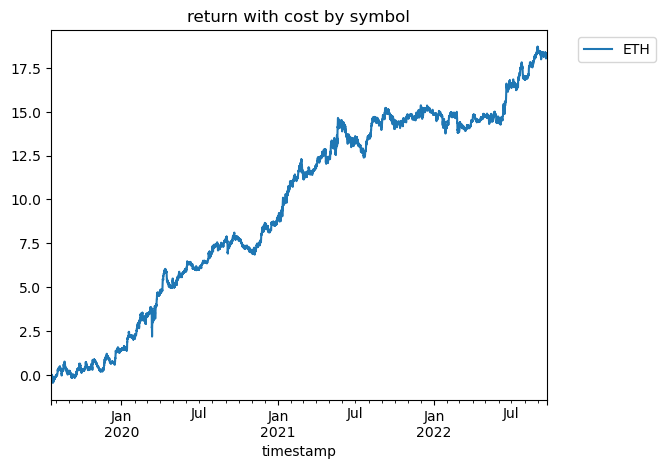

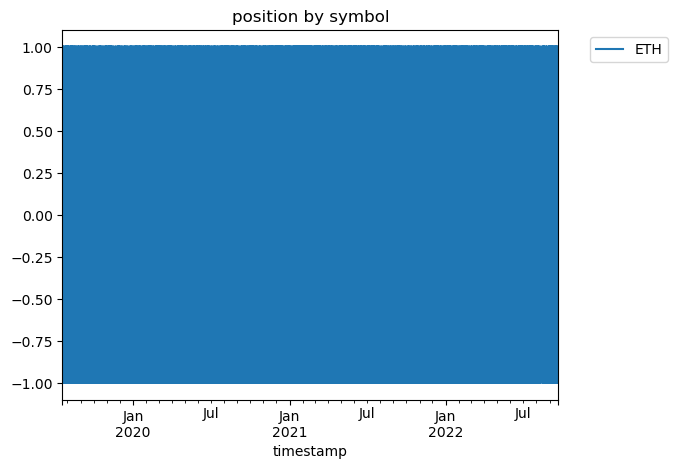

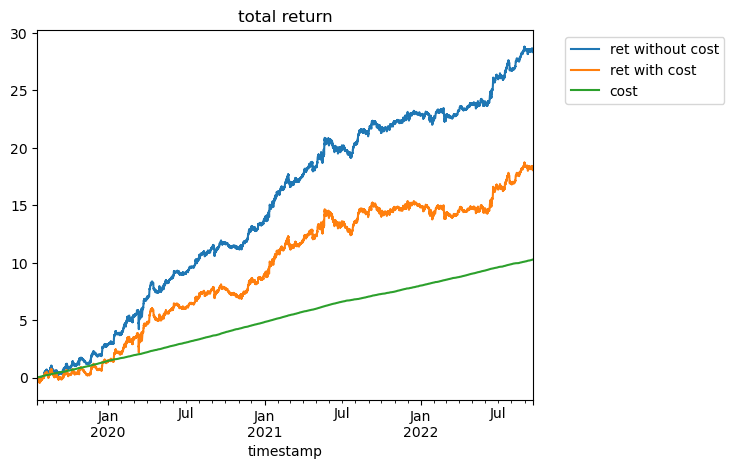

In [ ]:
df = pd.read_pickle('/tmp/df_horizon4.pkl')
# df = df.loc[df.index.get_level_values('symbol') == 'BTC']
df = df.loc[df.index.get_level_values('symbol') == 'ETH'] # good
# df = df.loc[df.index.get_level_values('symbol') == 'BNB']
# df = df.loc[df.index.get_level_values('symbol') == 'XRP']
# df = df.loc[df.index.get_level_values('symbol') == 'ATOM'] # good without cost
# df = df.loc[df.index.get_level_values('symbol') == 'LINK']
# df = df.loc[df.index.get_level_values('symbol') == 'DOT']
# df = df.loc[df.index.get_level_values('symbol') == 'MATIC'] # good without cost
# df = df.loc[df.index.get_level_values('symbol') == 'SOL'] # good without cost
# df = df.loc[df.index.get_level_values('symbol') == 'ADA']
df = df.copy()

model = ExampleModelRank()

# cv
calc_position_cv(model, df)
visualize_result(df.dropna(), execution_cost=0.0004)
# visualize_result(df.dropna(), execution_cost=0.001)

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20220921_eth.xz', 'wb') as f:
    f.write(data)

timestamp                  symbol
2022-09-07 13:00:00+00:00  ETH       1.0
2022-09-07 14:00:00+00:00  ETH       1.0
2022-09-07 15:00:00+00:00  ETH       1.0
2022-09-07 16:00:00+00:00  ETH       1.0
2022-09-07 17:00:00+00:00  ETH       1.0
                                    ... 
2022-09-21 09:00:00+00:00  ETH       1.0
2022-09-21 10:00:00+00:00  ETH       1.0
2022-09-21 11:00:00+00:00  ETH      -1.0
2022-09-21 12:00:00+00:00  ETH       1.0
2022-09-21 13:00:00+00:00  ETH       1.0
Name: position, Length: 337, dtype: float64
['ETH']
test shift predict


,,position1,position2,position3
timestamp,symbol,,,
2022-09-07 14:00:00+00:00,ETH,1.0,1.0,1.0
2022-09-07 15:00:00+00:00,ETH,1.0,1.0,-1.0
2022-09-07 16:00:00+00:00,ETH,1.0,1.0,1.0
2022-09-07 17:00:00+00:00,ETH,1.0,1.0,1.0
2022-09-07 18:00:00+00:00,ETH,1.0,1.0,1.0
...,...,...,...,...
2022-09-21 08:00:00+00:00,ETH,1.0,1.0,1.0
2022-09-21 09:00:00+00:00,ETH,1.0,1.0,1.0
2022-09-21 10:00:00+00:00,ETH,1.0,1.0,1.0


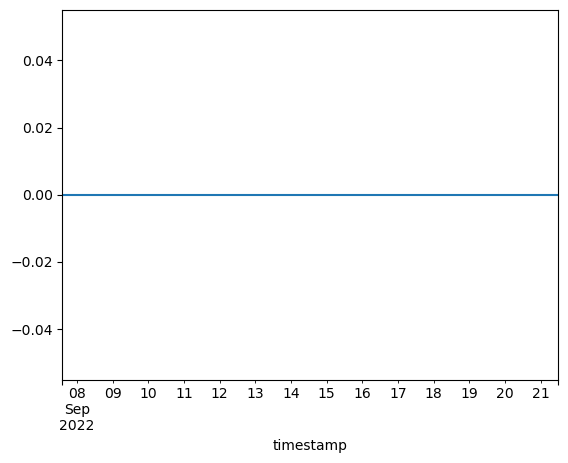

ETH (335, 4)


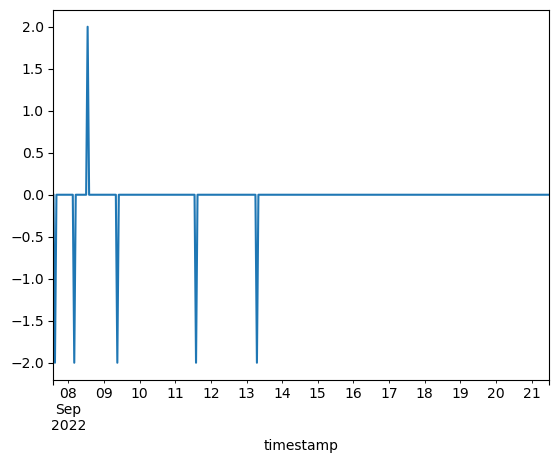

ETH (337, 3)


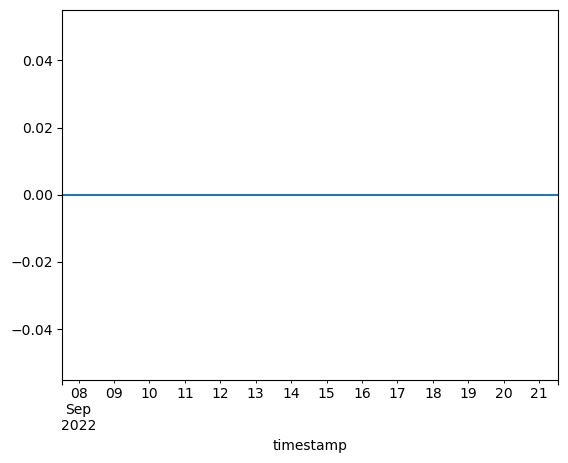

In [4]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/20220921_eth.xz')
df = pd.read_pickle('/tmp/df_horizon4.pkl')
df = df.loc[df.index.get_level_values('symbol') == 'ETH']
df = df[['op', 'hi', 'lo', 'cl']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

def _calc_features(df):        
    df = df.copy()

    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))

    for col in get_feature_columns(df):
        df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5

    return df

df_features1 = _calc_features(df)
df_features3 = _calc_features(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()

df_test2 = pd.concat([
    df_features1['feature_rsi_72'].rename('feature1'),
    df_features3['feature_rsi_72'].rename('feature3'),
    # df_features1['feature_momentum_72'].rename('feature1'),
    # df_features3['feature_momentum_72'].rename('feature3'),
], axis=1)

for symbol, df_symbol in df_test2.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['feature3'] - df_symbol['feature1']).plot()
plt.show()